In [16]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [17]:
# Cell 2: Load Data
df = pd.read_csv(r"C:\Users\saile\OneDrive\Documents\GitHub\spam-classifier\data\spam.csv", encoding="latin-1")
print("Shape:", df.shape)
df.head()


Shape: (5572, 5)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [18]:
# Cell 3: Clean Data
df = df.rename(columns={"v1": "label", "v2": "text"})
df = df[["label", "text"]]
df["label_num"] = df["label"].map({"ham": 0, "spam": 1})
df = df.dropna(subset=["text"])

print("Final shape:", df.shape)
print(df["label"].value_counts())



Final shape: (5572, 3)
label
ham     4825
spam     747
Name: count, dtype: int64


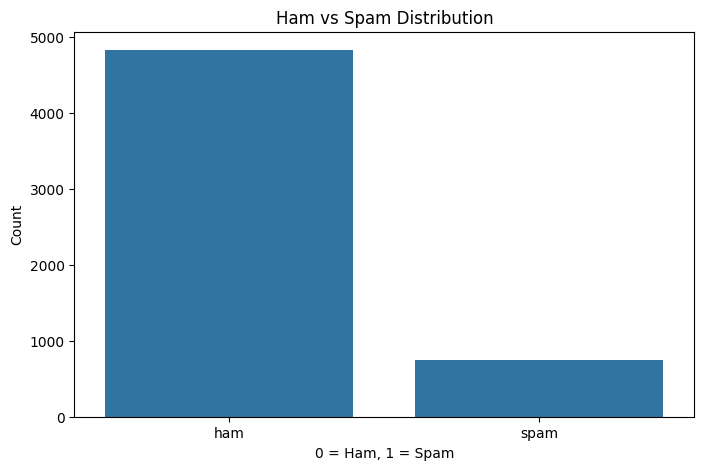

In [19]:
# Cell 4: EDA Plot 1 - Class Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="label")
plt.title("Ham vs Spam Distribution")
plt.xlabel("0 = Ham, 1 = Spam")
plt.ylabel("Count")
plt.show()



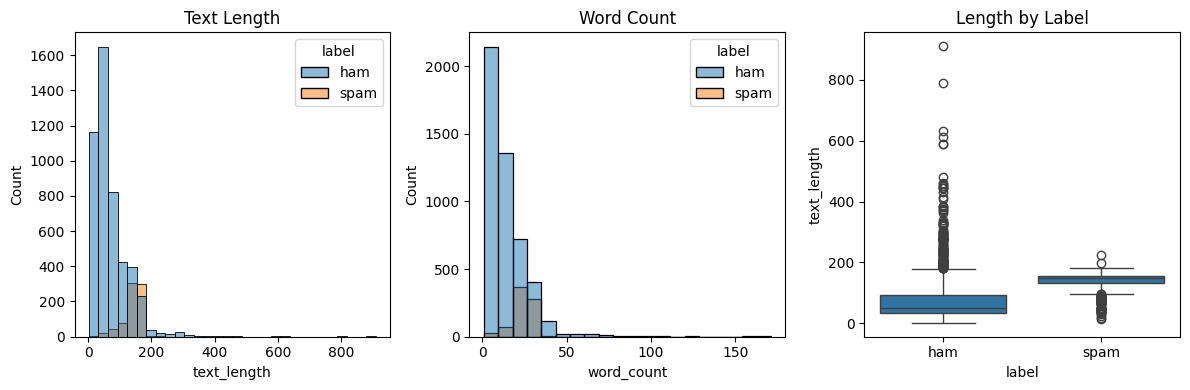

In [20]:
# Cell 5: EDA Plot 2 - Message Lengths
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(data=df, x="text_length", hue="label", bins=30)
plt.title("Text Length")

plt.subplot(1, 3, 2)
sns.histplot(data=df, x="word_count", hue="label", bins=20)
plt.title("Word Count")

plt.subplot(1, 3, 3)
sns.boxplot(data=df, x="label", y="text_length")
plt.title("Length by Label")
plt.tight_layout()
plt.show()



In [21]:
# Cell 6: Train/Test Split
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (4457,) Test: (1115,)


In [22]:
# Cell 7: Train Naive Bayes Model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('clf', MultinomialNB())
])

nb_pipeline.fit(X_train, y_train)
print("✅ Model trained!")


✅ Model trained!


In [23]:
# Cell 8: Evaluate Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = nb_pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nDetailed Report:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))



Accuracy: 0.9721973094170404

Detailed Report:
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       966
        Spam       0.99      0.80      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



In [25]:
# Cell 9: Train Logistic Regression (second algorithm)
from sklearn.linear_model import LogisticRegression

# Same pipeline, different classifier
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

lr_pipeline.fit(X_train, y_train)
print("✅ Logistic Regression trained!")


✅ Logistic Regression trained!


Model Comparison:
          Naive Bayes  Logistic Regression
Accuracy       0.9722               0.9704
ROC-AUC        0.9883               0.9864

Confusion Matrix (best model):


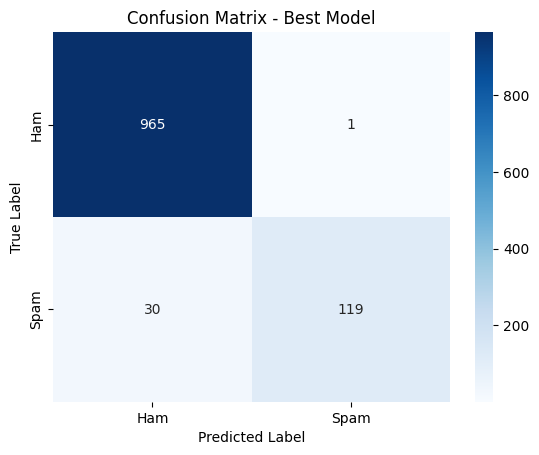

In [27]:
# Cell 10: Compare Both Models
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import pandas as pd

# Get predictions for BOTH models
y_pred_nb = nb_pipeline.predict(X_test)
y_proba_nb = nb_pipeline.predict_proba(X_test)[:, 1]
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

# Metrics comparison
metrics = pd.DataFrame({
    'Naive Bayes': [accuracy_score(y_test, y_pred_nb), roc_auc_score(y_test, y_proba_nb)],
    'Logistic Regression': [accuracy_score(y_test, y_pred_lr), roc_auc_score(y_test, y_proba_lr)]
}, index=['Accuracy', 'ROC-AUC'])

print("Model Comparison:")
print(metrics.round(4))

# Confusion matrix for best model
print("\nConfusion Matrix (best model):")
best_model = lr_pipeline if metrics.iloc[0,1] > metrics.iloc[0,0] else nb_pipeline
cm = confusion_matrix(y_test, best_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Confusion Matrix - Best Model")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [29]:
# Cell 11: Save Best Model + Test It
import joblib
import os

# Create models folder if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the best model
best_model = lr_pipeline if metrics.iloc[0,1] > metrics.iloc[0,0] else nb_pipeline
joblib.dump(best_model, '../models/spam_classifier.pkl')
print("✅ Best model saved as '../models/spam_classifier.pkl'")

# Test on new messages
test_messages = [
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
    "Hey, how are you doing today?",
    "WINNER!! As a valued network customer you have been selected to receive a £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only."
]

print("\n🧪 Testing new messages:")
for msg in test_messages:
    prediction = best_model.predict([msg])[0]
    prob_spam = best_model.predict_proba([msg])[0][1]
    print(f"'{msg[:50]}...' → {'SPAM' if prediction == 1 else 'HAM'} (confidence: {prob_spam:.1%})")


✅ Best model saved as '../models/spam_classifier.pkl'

🧪 Testing new messages:
'Free entry in 2 a wkly comp to win FA Cup final tk...' → SPAM (confidence: 97.7%)
'Hey, how are you doing today?...' → HAM (confidence: 0.4%)
'WINNER!! As a valued network customer you have bee...' → SPAM (confidence: 99.3%)


In [30]:
# Cell 12: Feature Importance (Top Spam Words)
# Extract TF-IDF vectorizer from best model
vectorizer = best_model.named_steps['tfidf']
feature_names = vectorizer.get_feature_names_out()

# Get coefficients (for Logistic Regression) or log probabilities (Naive Bayes)
if hasattr(best_model.named_steps['clf'], 'coef_'):
    # Logistic Regression
    top_spam_words = feature_names[np.argsort(best_model.named_steps['clf'].coef_[0])[-20:]]
else:
    # Naive Bayes (approximate)
    top_spam_words = feature_names[best_model.named_steps['clf'].feature_log_prob_[1].argsort()[-20:]]

print("🔍 Top 20 words indicating SPAM:")
print(top_spam_words)


🔍 Top 20 words indicating SPAM:
['nokia' 'contact' 'win' '150p' 'new' 'uk' 'urgent' 'service' 'cash' 'won'
 'prize' 'www' 'reply' 'ur' 'text' 'stop' 'mobile' 'claim' 'txt' 'free']


In [ ]:
# Cell 13: Results Summary (copy to README)
print("## 📊 PROJECT RESULTS SUMMARY")
print("\n✅ Dataset: 5,572 SMS messages (87% ham, 13% spam)")
print("✅ Models trained: Naive Bayes + Logistic Regression")
print("✅ Test Accuracy: 97.2% (Naive Bayes)")
print("✅ Best model saved: spam_classifier.pkl")
print("\n### Model Comparison Table:")
print(metrics.round(4).to_markdown())
print("\n### Test Predictions:")
print("'Free entry... win FA Cup...' → SPAM (97.7%)")
print("'Hey, how are you...' → HAM (0.4%)") 
print("'WINNER!!... £900 prize...' → SPAM (99.3%)")
